In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from skimage import io
from torch.utils.data import DataLoader, Dataset

In [3]:
# load dataset
train_dir = "train"
test_dir = "test"
train_csv = "train_data.csv"
test_csv = "test_data.csv"

transforms = transforms.Compose([transforms.Resize((105,105)), transforms.ToTensor()])

In [4]:
class SiameseData(Dataset):
    def __init__(self, train_csv=None, train_dir=None, transform=None):
        self.train_df = pd.read_csv(train_csv)
        self.train_df.columns = ["image1", "image2", "image3"]
        self.train_dir = train_dir
        self.transform = transform

    def __getitem__(self, index):
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])
        img1 = io.imread(image1_path)
        img2 = io.imread(image2_path)

        # Convert to PIL Image before applying .convert()
        img1 = Image.fromarray(img1).convert("L")
        img2 = Image.fromarray(img2).convert("L")

        # apply image transormations
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (
            img1,
            img2,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)

In [5]:
# create a siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.3),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.3),
        )
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2),
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [6]:
class ContrastiveLoss(nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(
            output1, output2, keepdim=True
        )  # Calculate distance between output1 and output2
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

In [7]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork()
model = model.to(device)

criterion = ContrastiveLoss()

train_ds = SiameseData(train_csv, train_dir, transform=transforms)
test_ds = SiameseData(test_csv, test_dir, transform=transforms)

train_dl = DataLoader(
    train_ds, shuffle=True, num_workers=8, pin_memory=True, batch_size=32
)
test_dl = DataLoader(
    test_ds, shuffle=False, num_workers=8, pin_memory=True, batch_size=32
)

In [8]:
# train the model
def train(epochs, max_lr, model, train_dl, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    losses = []

    optimizer = opt_func(model.parameters(), max_lr)
    # one cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl)
    )

    for epoch in range(1, epochs):
        for batch_idx, (data) in enumerate(train_dl):  # Modified line: removed targets
            img0, img1, label = data
            # img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            # Move data to the device
            img0, img1, label = (
                img0.to(device),
                img1.to(device),
                label.to(device),
            )  # Added line
            optimizer.zero_grad()
            # forward
            output1, output2 = model(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            losses.append(loss_contrastive.item())  # Changed loss to loss_contrastive
            # adam step
            optimizer.step()
        print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")
    return model


epochs = 5
max_lr = 0.01
opt_func = torch.optim.Adam

history = train(epochs, max_lr, model, train_dl, opt_func)

# save the model
torch.save(history.state_dict(), "model.pt")

Cost at epoch 1 is 1.1115785299828558
Cost at epoch 2 is 0.8340618225640666
Cost at epoch 3 is 0.6197986235517985
Cost at epoch 4 is 0.47932280913125547


In [9]:
# Load the state dictionary from the file
state_dict = torch.load("model.pt", weights_only=True)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

<All keys matched successfully>

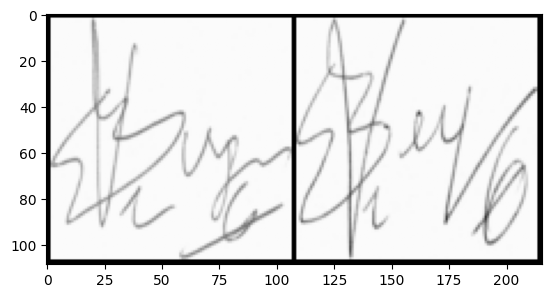

Predicted Eucledian Distance: 7.626530647277832
Actual Label: Forged Pair Of Signature


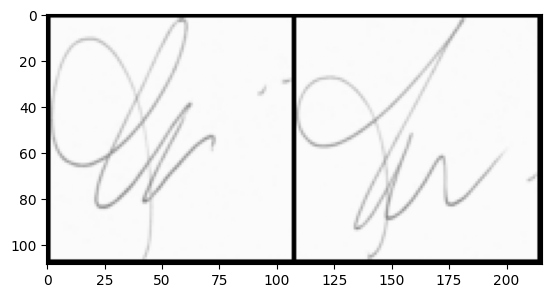

Predicted Eucledian Distance: 0.013440071605145931
Actual Label: Original Pair Of Signature


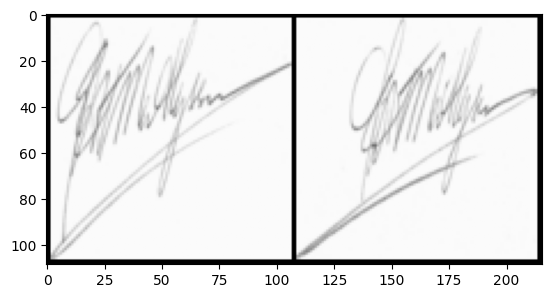

Predicted Eucledian Distance: 0.15492048859596252
Actual Label: Original Pair Of Signature


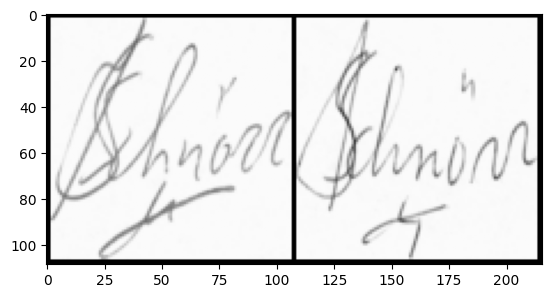

Predicted Eucledian Distance: 2.414555072784424
Actual Label: Forged Pair Of Signature


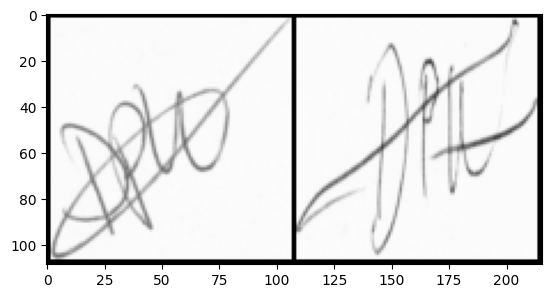

Predicted Eucledian Distance: 6.404932498931885
Actual Label: Forged Pair Of Signature


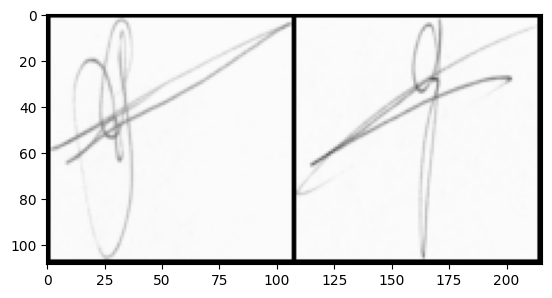

Predicted Eucledian Distance: 2.5064406394958496
Actual Label: Forged Pair Of Signature


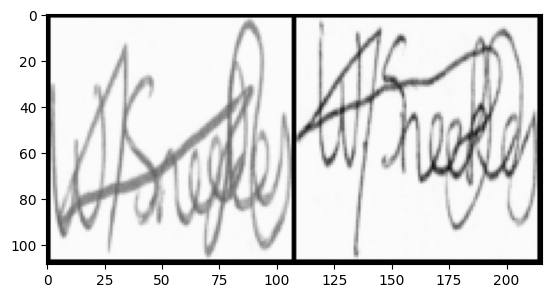

Predicted Eucledian Distance: 6.709883213043213
Actual Label: Forged Pair Of Signature


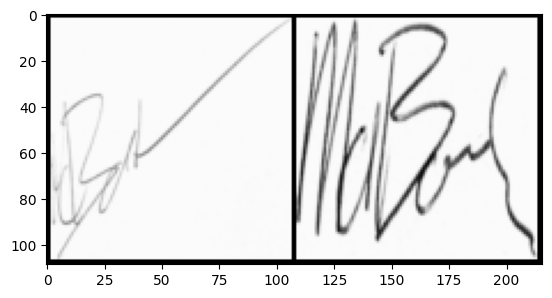

Predicted Eucledian Distance: 12.517598152160645
Actual Label: Forged Pair Of Signature


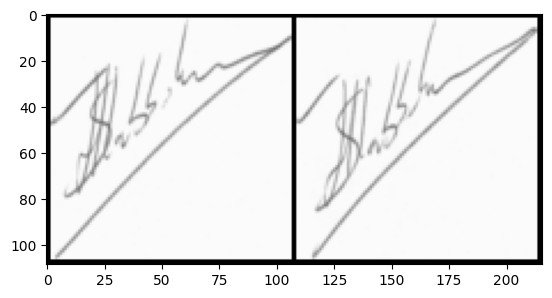

Predicted Eucledian Distance: 0.04646411910653114
Actual Label: Original Pair Of Signature


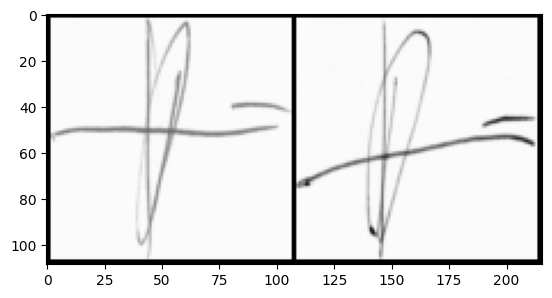

Predicted Eucledian Distance: 14.351837158203125
Actual Label: Forged Pair Of Signature


In [10]:
# Load the test data set
test_dataset = SiameseData(
    train_csv=test_csv,
    train_dir=test_dir,
    transform=transforms,
)

test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)
# test the network
count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = model(x0.to(device), x1.to(device))

    eucledian_distance = F.pairwise_distance(output1, output2)

    if label == torch.FloatTensor([[0]]):
        label = "Original Pair Of Signature"
    else:
        label = "Forged Pair Of Signature"

    plt.imshow(torchvision.utils.make_grid(concat, nrow=concat.shape[0]).permute(1, 2, 0))
    plt.show()
    print("Predicted Eucledian Distance:", eucledian_distance.item())
    print("Actual Label:", label)
    count = count + 1
    if count == 10:
        break